In [187]:
models = ['clip', 'albef', 'vilt']
metrics = ['standard_pearson']

In [286]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch

from fsk.dataprep.utils import (
    get_concepts_info, get_feature_idx_map, get_fsk, 
    get_fsk_features, get_fsk_synsets, get_synsets_ids
)

from fsk.similarity.sem_distances import get_mcrae_features

from IPython.display import Image
#pd.set_option('display.max_rows', None)

In [189]:
project_path = Path('/Users/m_vilas/projects/fsk-multimodal')
res_path = project_path / 'results/'
image_path = project_path / 'dataset/things/object_images'

In [190]:
# Synsets and Concepts data
s_ids, concepts = get_synsets_ids(project_path / 'dataset')
mcrae_concepts = concepts['mcrae']
things_concepts = concepts['things']
synsets = get_fsk_synsets(project_path / 'dataset') # real order of synsets
concepts_info = get_concepts_info(project_path / 'dataset')

# Features data
fsk = get_fsk(project_path / 'dataset')
ft_idx = get_feature_idx_map(project_path / 'dataset/annotations')
ft_idx = {val: key for key, val in ft_idx.items()}
fsk_ft = get_fsk_features(project_path / 'dataset')
mcrae_ft = get_mcrae_features(project_path, list(s_ids.keys()), mcrae_concepts, None)
sem_ft = mcrae_ft.values

# Concept Match

In [191]:
top_k = [1, 5, 10]

c_preds = {}
for m in models:
    m_preds = []
    c_match_path = res_path / m / 'concept_match'
    for s, s_imgs in s_ids.items():
        correct_val = synsets.index(s)
        for img in s_imgs:
            val = [s, img]
            i_pred = torch.load(c_match_path / f'{img}.pt', map_location=torch.device('cpu'))
            top_indices = i_pred.topk(15)[1]
            val.append([synsets[i] for i in top_indices])
            for t in top_k:
                val.append(correct_val in top_indices[:t])
            m_preds.append(val)
    c_preds[m] = pd.DataFrame(m_preds, columns=['synset', 'image', 'preds', 'top1', 'top5', 'top10'])
    print(m)
    print(f"Top1 accuracy: {c_preds[m]['top1'].mean()}")
    print(f"Top5 accuracy: {c_preds[m]['top5'].mean()}")
    print(f"Top10 accuracy: {c_preds[m]['top10'].mean()}")


clip
Top1 accuracy: 0.34517045454545453
Top5 accuracy: 0.42410714285714285
Top10 accuracy: 0.4472402597402597
albef
Top1 accuracy: 0.336038961038961
Top5 accuracy: 0.4224837662337662
Top10 accuracy: 0.43973214285714285
vilt
Top1 accuracy: 0.237012987012987
Top5 accuracy: 0.3612012987012987
Top10 accuracy: 0.4028003246753247


_TODO_: convert into plot

# Feature match

### Overall accuracy

In [192]:
f_preds = {}
for m in models:
    m_preds = []
    f_match_path = res_path / m / 'feature_match'
    for s, s_imgs in s_ids.items():
        s_info = fsk.loc[fsk['synsets'] == s]
        n_features = len(s_info)
        top_k_i = [n_features, (n_features * 2)]
        for img in s_imgs:
            i_pred = torch.load(f_match_path / f'{img}.pt', map_location=torch.device('cpu'))
            top_indices = i_pred.topk(n_features * 2)[1]
            for _, f in s_info.iterrows():
                val = [s, img, f['features'], f['features_type']]
                correct_val = int(f['features_idx'])
                val.append([ft_idx[int(i)] for i in top_indices])
                for t in top_k_i:
                    val.append(correct_val in top_indices[:t])
                val.append(i_pred[correct_val].detach().numpy())
                m_preds.append(val)
    f_preds[m] = pd.DataFrame(
        m_preds, 
        columns=['synset', 'image', 'feature', 'feature_type', 'preds', 'top1', 'top2', 'pred_val']
    )
    print(m)
    print(f"Top1 accuracy: {f_preds[m]['top1'].mean()}")
    print(f"Top2 accuracy: {f_preds[m]['top2'].mean()}")

clip
Top1 accuracy: 0.21163178203928906
Top2 accuracy: 0.29766428905519177
albef
Top1 accuracy: 0.1541013797942002
Top2 accuracy: 0.2236172825070159
vilt
Top1 accuracy: 0.12624239943872778
Top2 accuracy: 0.19282039289055192


### Accuracy by feature type

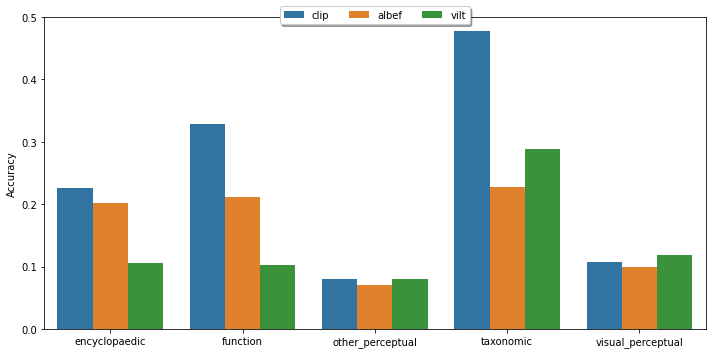

In [193]:
mean_by_f = []
for m in models:
    m_data = f_preds[m].groupby('feature_type').mean().reset_index()
    m_data['model'] = m
    mean_by_f.append(m_data)
mean_by_f = pd.concat(mean_by_f)
mean_by_f = mean_by_f.drop('top2', axis=1)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    x='feature_type', y='top1', hue='model', 
    data=mean_by_f, hue_order=['clip', 'albef', 'vilt']
)
ax.set(ylim=(0, 0.5))
ax.set(xlabel=None, ylabel='Accuracy')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

In [194]:
for m in models:
    m_preds = []
    f_match_path = res_path / m / 'feature_match'
    for s, s_imgs in s_ids.items():
        s_info = fsk.loc[fsk['synsets'] == s]
        n_features = len(s_info)
        for img in s_imgs:
            i_pred = torch.load(f_match_path / f'{img}.pt', map_location=torch.device('cpu'))
            top_indices = i_pred.topk(n_features)[1]
            m_preds.append(
                [s, img, [ft_idx[int(i)] for i in top_indices], s_info['features'].tolist()]
            )
    m_preds = pd.DataFrame(m_preds, columns=['synset', 'image', 'features', 'preds'])
    m_preds.to_csv(res_path / 'pred_inspection' / f'{m}_feature_preds.csv')
    

#### Questions

2. Plot most and least activating images of a particular feature
3. Do some features depend that the concept is activated to be recognized? (indirect measure of how global the recognition must be)
4. Do words importance

#### Ideas
1. You train classifier over network to separate the two groups of images for a particular feature. You predict images that lie on one end and the other, and see their commonalities

### Search
1. How to get commonalities of images and also word spaces?

# Concept detection via feature-prediction

What concepts we can extract if we base it on the predictions of the network?

In [195]:
for met in metrics:
    if 'standard' in met:
        sem_ft = StandardScaler().fit_transform(mcrae_ft.values)
    for m in models:
        acc = 0
        f_match_path = project_path / 'results' / m / 'feature_match'
        syns = []
        imgs = []
        preds = []
        for s, s_imgs in s_ids.items():
            for img in s_imgs:
                i_pred = torch.load(f_match_path / f'{img}.pt', map_location=torch.device('cpu'))
                preds.append(i_pred.unsqueeze(dim=0).detach().numpy())
                syns.append(s)
                imgs.append(img)
        preds = np.squeeze(np.array(preds))

        # Standard Scaler
        if 'standard' in met:
            preds = StandardScaler().fit_transform(preds)
        # Cosine
        if 'cosine' in met:
            dist = cdist(preds, sem_ft, 'cosine')
        # Pearson
        elif 'pearson' in met:
            dist = cdist(preds, sem_ft, 'correlation')

        top_preds = []
        for i in range(len(dist)):
            top_indices = np.argsort(dist[i])[:10]
            concept_preds = [synsets[i] for i in top_indices]
            if syns[i] in concept_preds:
                acc += 1 
            top_preds.append(concept_preds)

        m_preds = pd.DataFrame({'synset':syns, 'image':imgs, 'top_preds':top_preds})
        m_preds.to_csv(res_path / 'pred_inspection' / f'{m}_{met}_concept_detection.csv')
        
        print(f'accuracy of {m} with {met}: {acc / len(top_preds)}')
            

accuracy of clip with standard_pearson: 0.38636363636363635
accuracy of albef with standard_pearson: 0.37094155844155846
accuracy of vilt with standard_pearson: 0.3013392857142857


__Standarized Pearson__ gave best results.

__Results with Cosine Distance__
- CLIP: 0.081
- ALBEF: 0.35
- ViLT: 0.16

__Results with Standarized Cosine Distance__
accuracy of clip with standard_cosine: 0.3599837662337662
accuracy of albef with standard_cosine: 0.36749188311688313
accuracy of vilt with standard_cosine: 0.28936688311688313

__Results with Pearson Distance__
accuracy of clip with pearson: 0.3778409090909091
accuracy of albef with pearson: 0.3575487012987013
accuracy of vilt with pearson: 0.27698863636363635

### TO-DO
- Do this feature-wise
- Can we say something about the other concepts being predicted?

# Inspecting feature predictions

Plot most and least activating images of a particular feature

In [196]:
f_acc = f_preds['clip'].groupby(['feature']).mean()
f_acc = pd.concat([f_acc, f_preds['clip']['feature'].value_counts().rename('counts')], axis=1)
f_acc.sort_values(by='counts', axis=0, ascending=False)[:50]

,top1,top2,counts
made_of_metal,0.000000,0.005865,1364
is_small,0.004664,0.025187,1072
an_animal,0.442987,0.733602,991
is_large,0.002312,0.016185,865
is_long,0.006135,0.015951,815
is_round,0.003989,0.007979,752
is_edible,0.025316,0.061885,711
made_of_wood,0.018868,0.039187,689
made_of_plastic,0.008319,0.011647,601
different_colours,0.027972,0.052448,572


####  Plot for a particular concept

In [197]:
#model = 'clip'
#model = 'albef'
model = 'vilt'

In [198]:
#f_probe = 'has_a_tail' # visual perceptual
#f_probe = 'an_animal' # taxonomic
#f_probe = 'is_edible'  # function
#f_probe = 'is_loud'  # other_peceptual
f_probe = 'found_in_kitchens' # encyclopaedic

- An animal in clip, is it the background or the classes themselves?

- Is edible in clip, is it the background ot the classes?

- ALBEF and VILT appear to have more class association

- is loud, all the models make the same associations

- found in kitchens, clip and albef very different

In [199]:
f_model = f_preds[model]
test = f_model.loc[f_model['feature']==f_probe].sort_values(by='pred_val', axis=0, ascending=False)

In [200]:
test[:10]

,synset,image,feature,feature_type,preds,top1,top2,pred_val
41587,oven-n-01,oven_02s,found_in_kitchens,encyclopaedic,"[has_an_oven, an_oven, made_in_ovens, found_in...",True,True,6.821955
41475,oven-n-01,oven_07s,found_in_kitchens,encyclopaedic,"[made_in_ovens, has_an_oven, an_oven, found_in...",True,True,6.508048
41559,oven-n-01,oven_09s,found_in_kitchens,encyclopaedic,"[has_an_oven, an_oven, found_in_kitchens, made...",True,True,6.4134912
41489,oven-n-01,oven_08s,found_in_kitchens,encyclopaedic,"[has_an_oven, made_in_ovens, an_oven, found_in...",True,True,6.180568
41503,oven-n-01,oven_12s,found_in_kitchens,encyclopaedic,"[has_an_oven, made_in_ovens, an_oven, found_in...",True,True,6.126911
59219,stove-n-01,stove1_03s,found_in_kitchens,encyclopaedic,"[used_on_stove_tops, made_in_ovens, has_an_ove...",False,True,6.1263547
41573,oven-n-01,oven_14s,found_in_kitchens,encyclopaedic,"[has_an_oven, made_of_stainless_steel, made_of...",True,True,5.7614837
59154,stove-n-01,stove1_04s,found_in_kitchens,encyclopaedic,"[used_on_stove_tops, made_in_ovens, used_for_h...",True,True,5.653459
22399,dishwasher-n-01,dishwasher_05s,found_in_kitchens,encyclopaedic,"[has_an_oven, an_oven, found_in_kitchens, used...",True,True,5.6174393
59180,stove-n-01,stove1_13s,found_in_kitchens,encyclopaedic,"[used_on_stove_tops, has_an_oven, an_oven, use...",False,True,5.5498276


In [201]:
test[-10:]

,synset,image,feature,feature_type,preds,top1,top2,pred_val
57340,spatula-n-01,spatula_02s,found_in_kitchens,encyclopaedic,"[has_a_concave_end/ladle, used_with_an_outlet,...",False,False,-8.441018
46533,plate-n-04,plate_12s,found_in_kitchens,encyclopaedic,"[is_oval, is_round, has_a_lid, a_basin, made_o...",False,False,-8.795024
17149,corkscrew-n-01,corkscrew_04s,found_in_kitchens,encyclopaedic,"[has_threads, has_needles, used_with_needles, ...",False,False,-8.92168
42260,pan-n-01,pan_16s,found_in_kitchens,encyclopaedic,"[made_with_flour, has_a_lid, made_of_flour, us...",False,False,-8.967746
57268,spatula-n-01,spatula_05s,found_in_kitchens,encyclopaedic,"[has_a_plug, used_with_an_outlet, has_a_cord, ...",False,False,-9.097555
57280,spatula-n-01,spatula_13s,found_in_kitchens,encyclopaedic,"[has_a_concave_end/ladle, is_serrated, has_a_c...",False,False,-9.1025095
55809,sink-n-01,sink_15n,found_in_kitchens,encyclopaedic,"[a_basin, is_sinkable, has_a_nozzle, a_tap, ha...",False,False,-9.1532
62724,tongs-n-01,tongs_03s,found_in_kitchens,encyclopaedic,"[is_twisted, an_axe, requires_sticks, has_2_bl...",False,False,-9.550412
55775,sink-n-01,sink_01b,found_in_kitchens,encyclopaedic,"[a_basin, is_sinkable, has_a_nozzle, a_tap, ha...",False,False,-10.278256
17199,corkscrew-n-01,corkscrew_03s,found_in_kitchens,encyclopaedic,"[a_tube, has_straps, has_a_wooden_handle, has_...",False,False,-10.415763


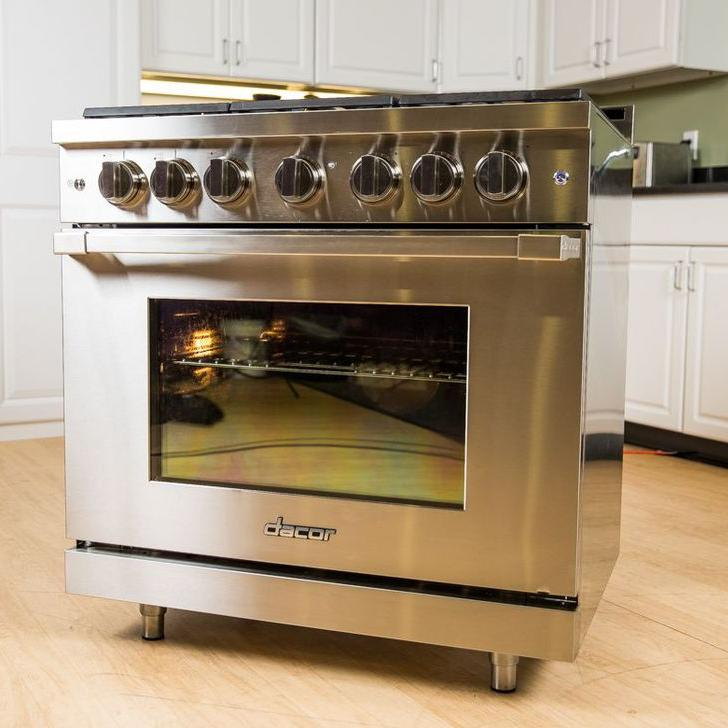

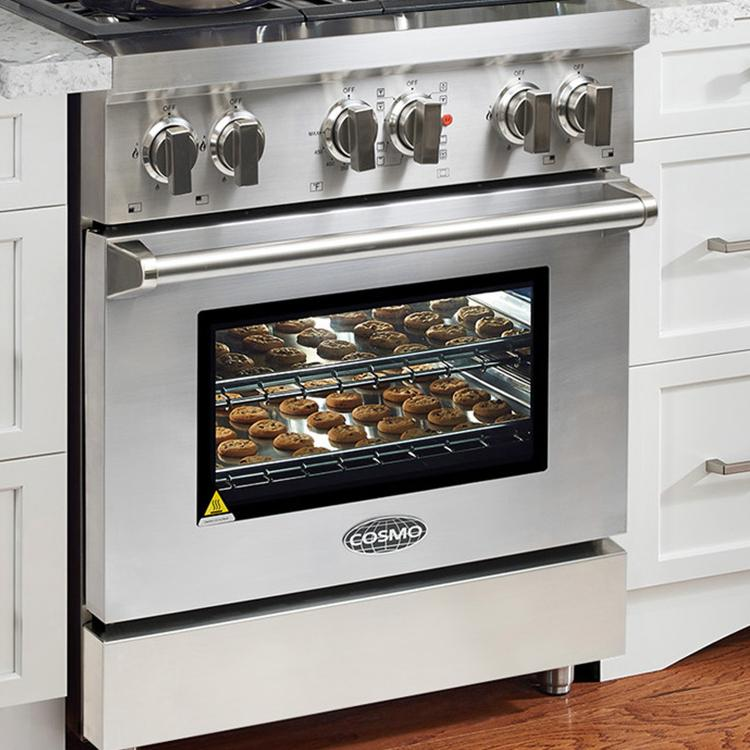

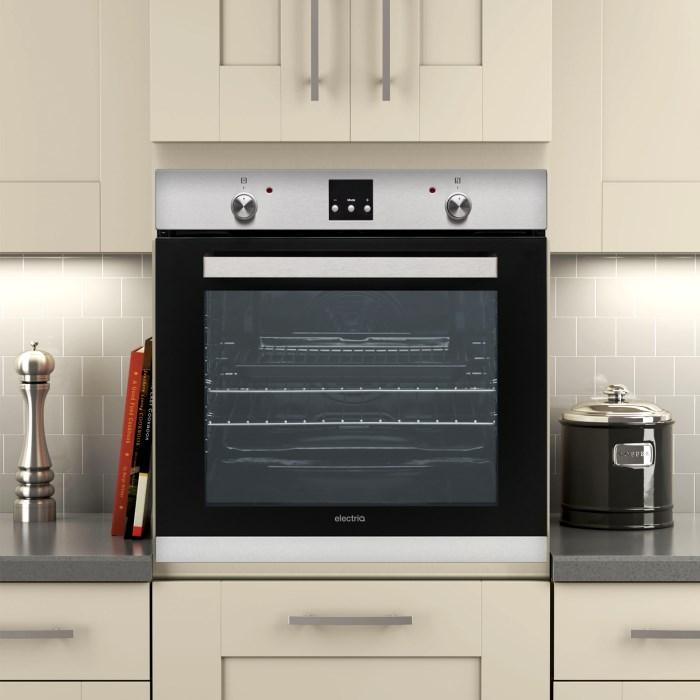

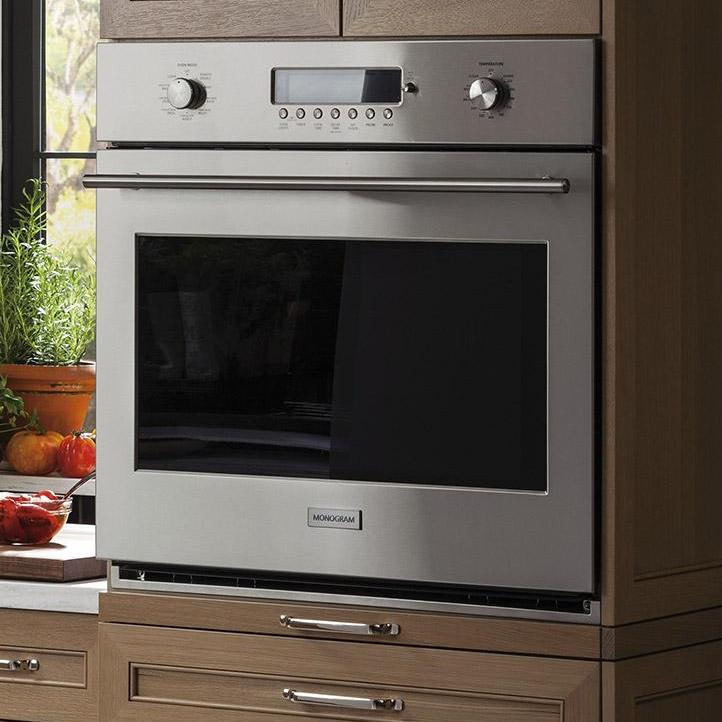

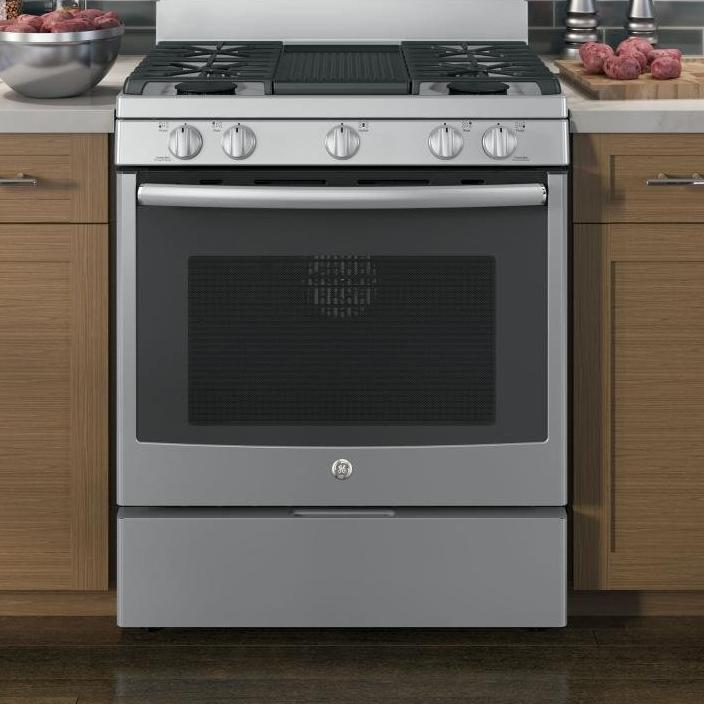

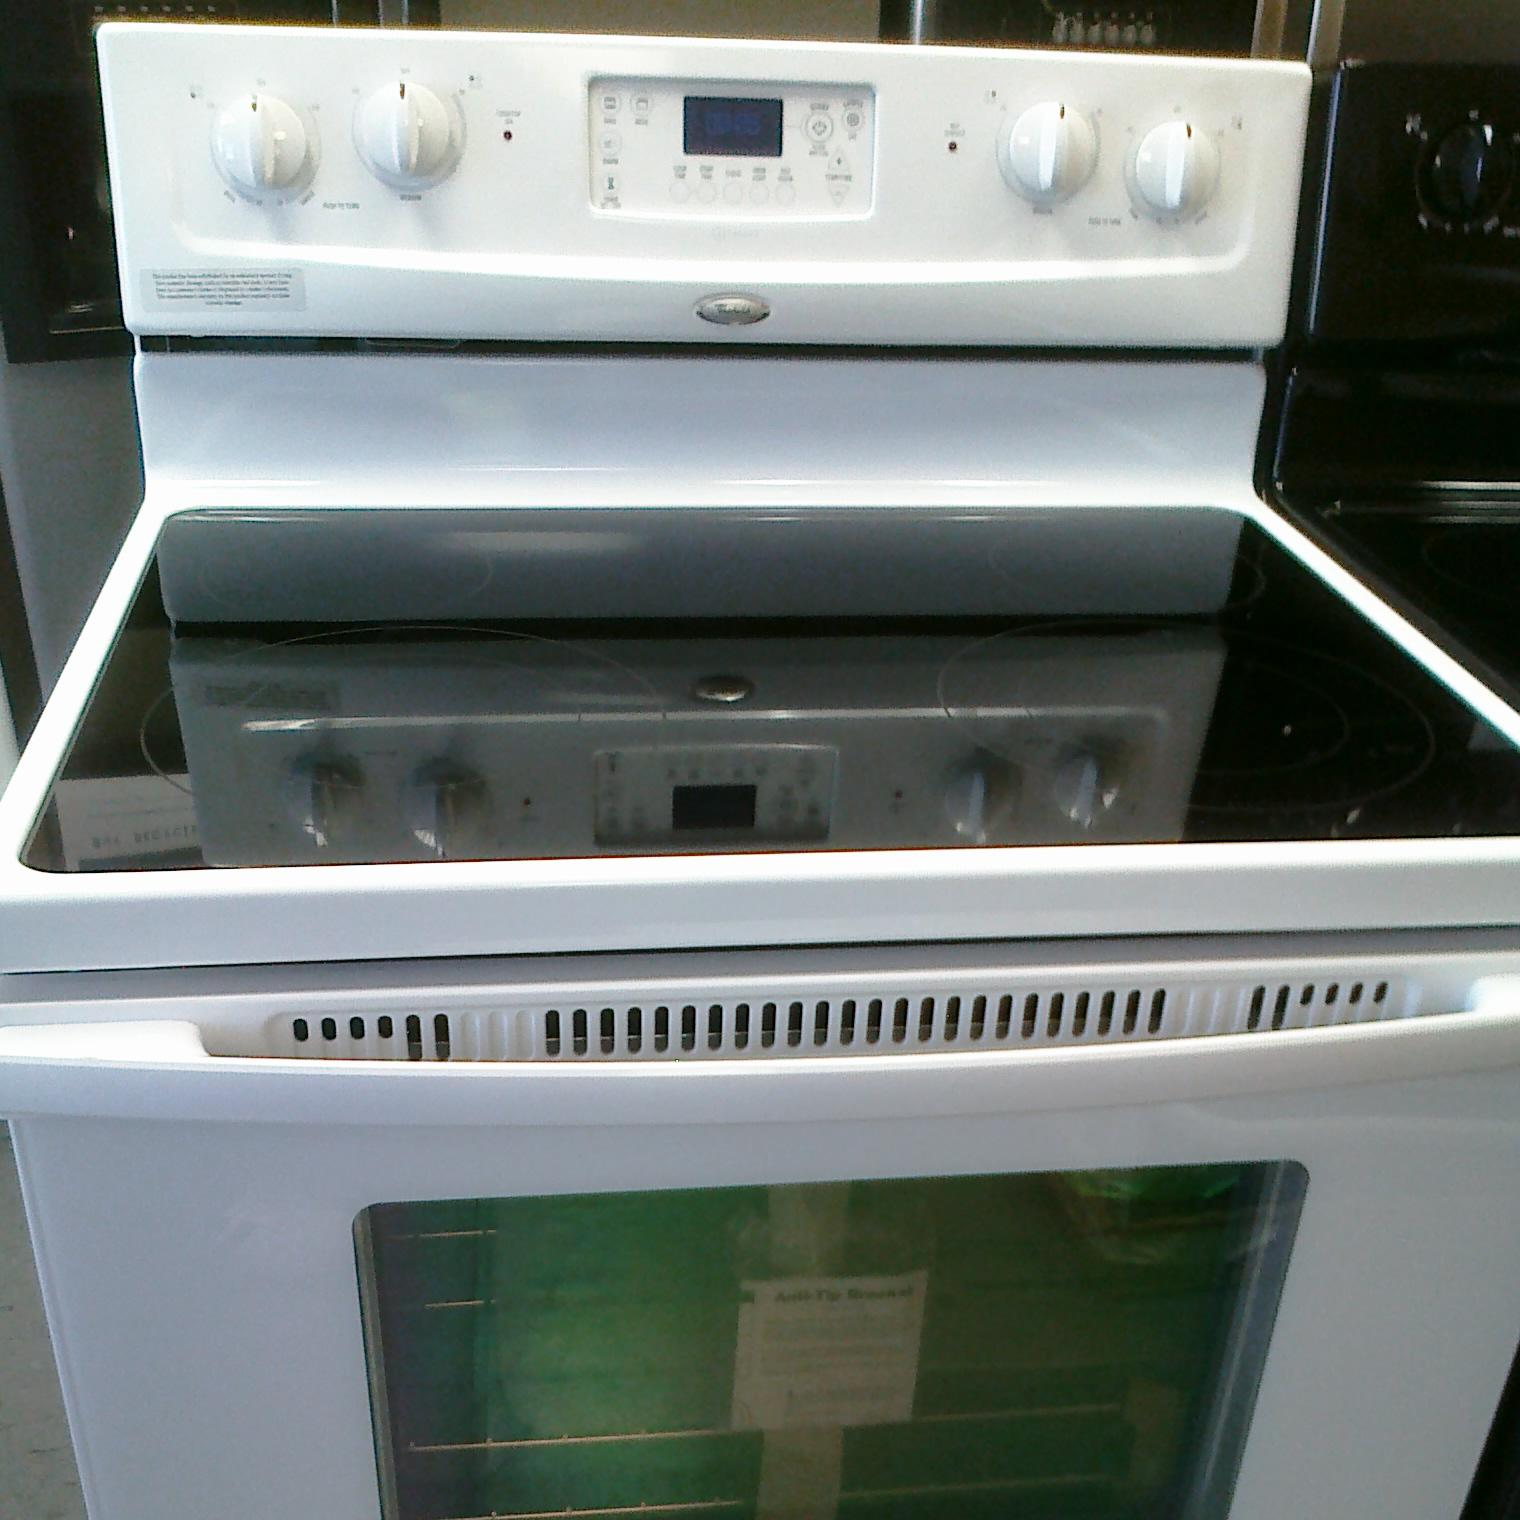

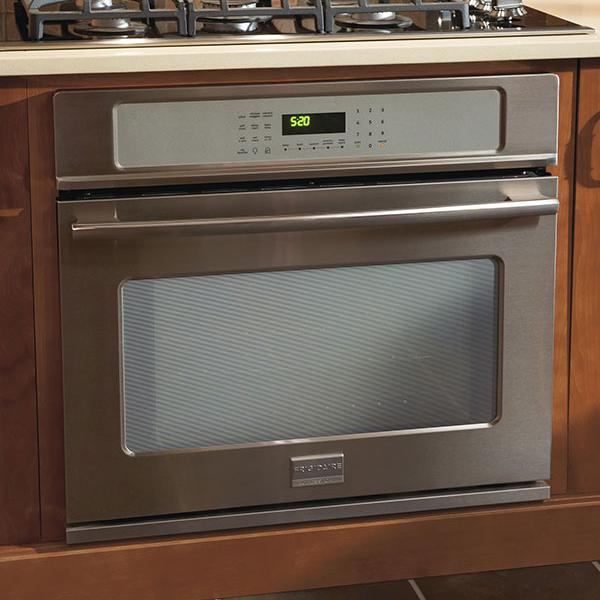

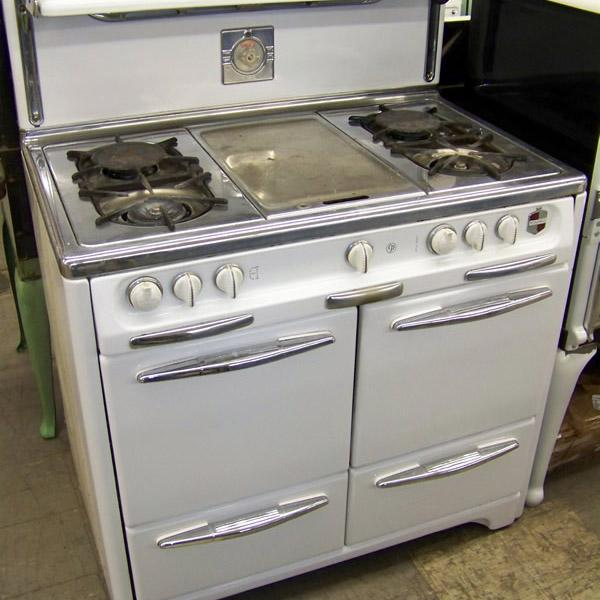

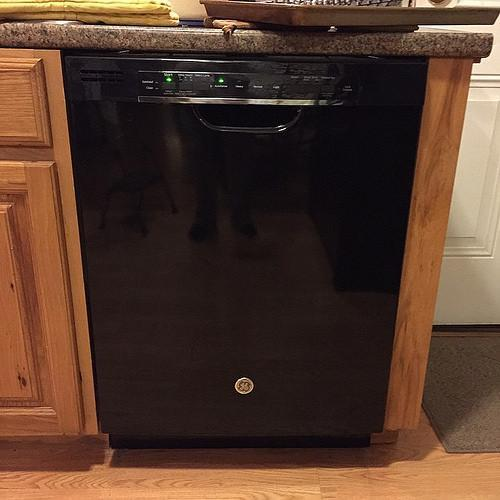

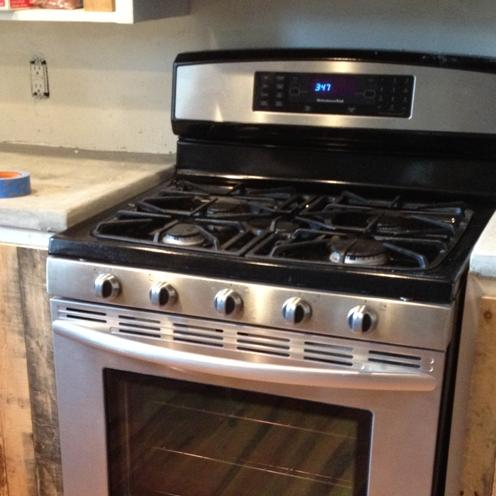

In [202]:
c_dict = pd.Series(
    concepts_info['ids_things'].values, index=concepts_info['synsets']
).to_dict()

for idx, row in test[:10].iterrows():
    i_path = image_path / c_dict[row['synset']] / f'{row["image"]}.jpg'
    display(Image(i_path, width=300))

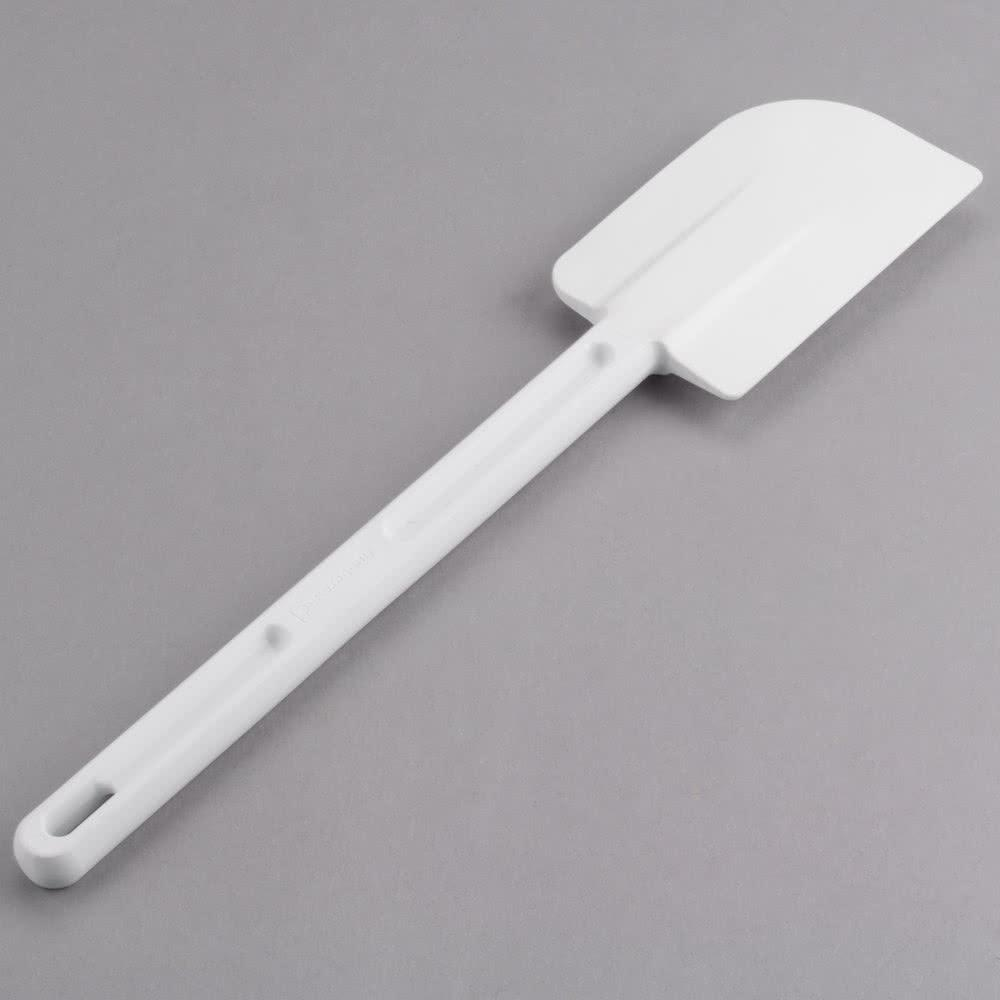

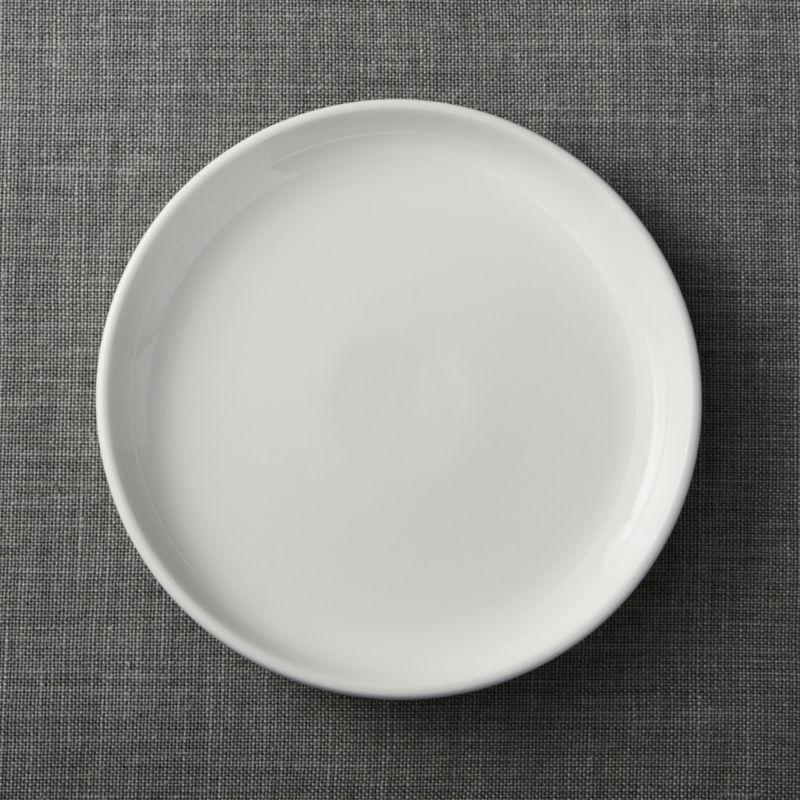

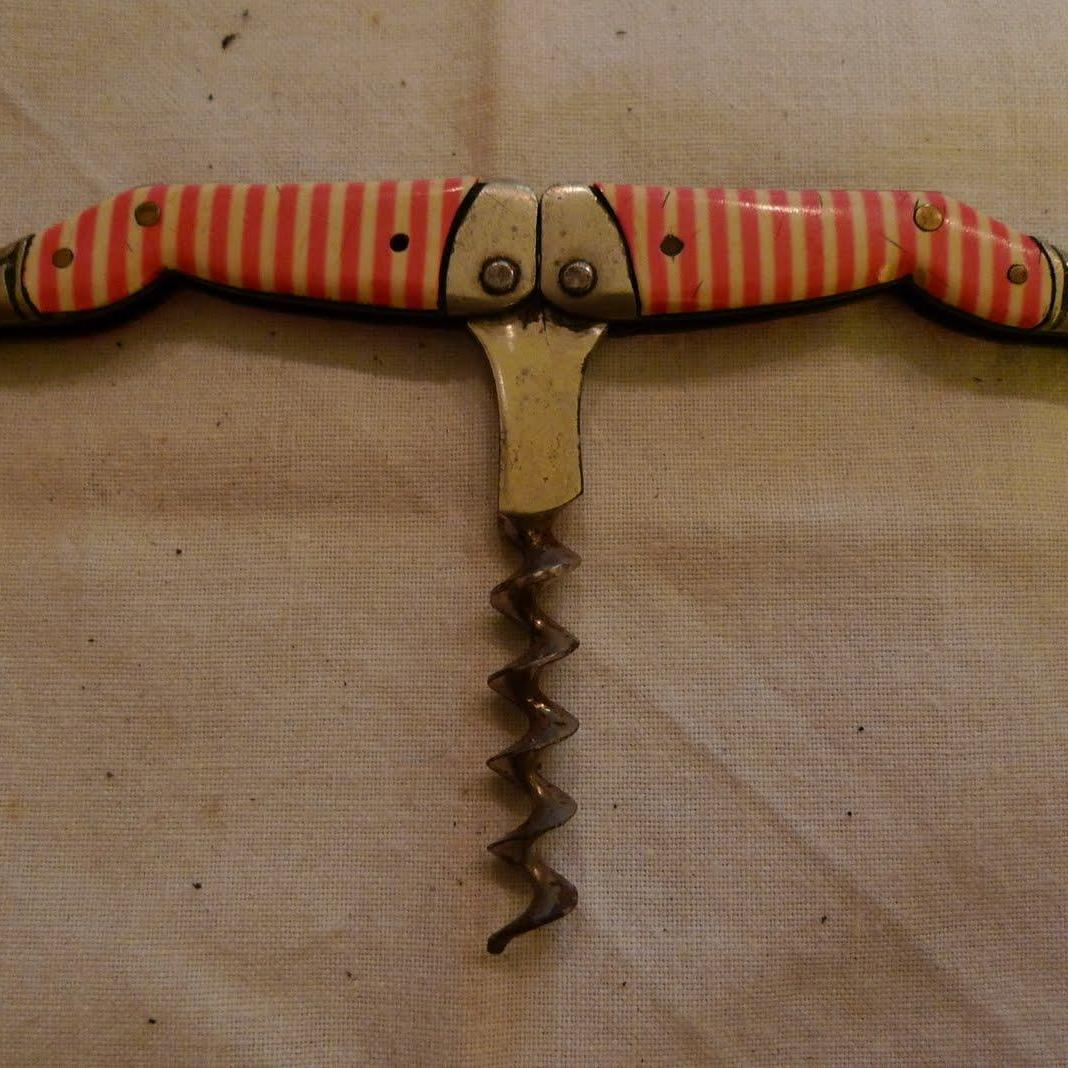

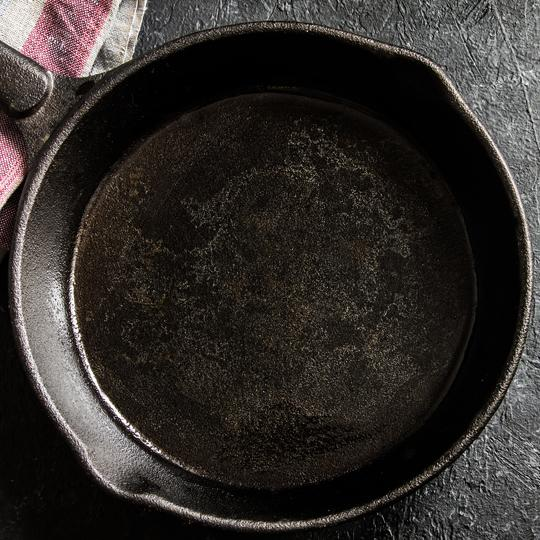

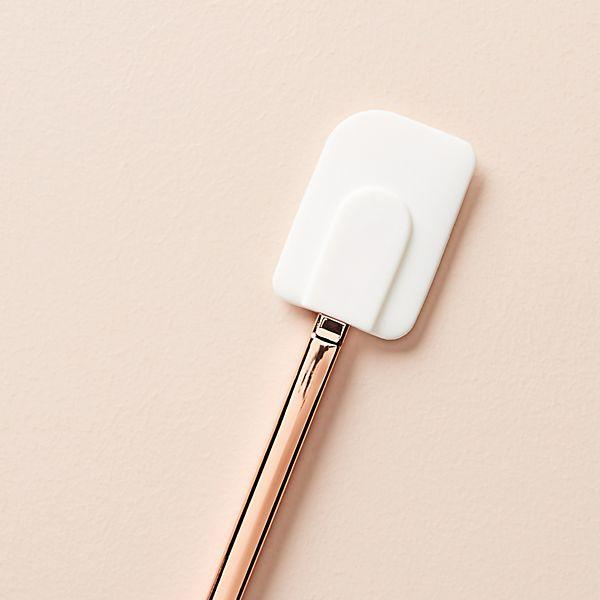

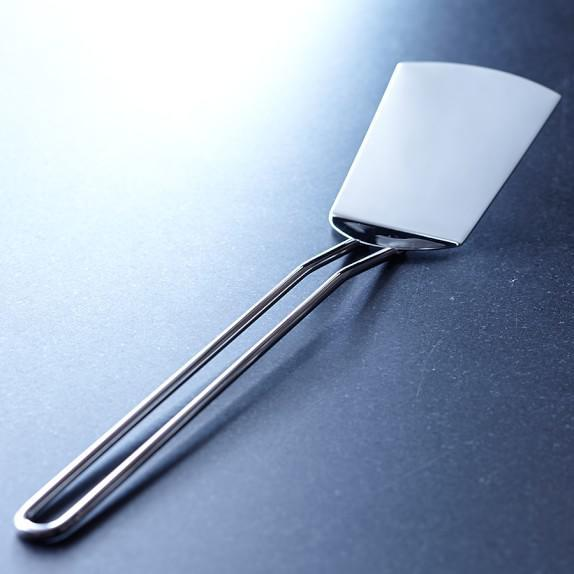

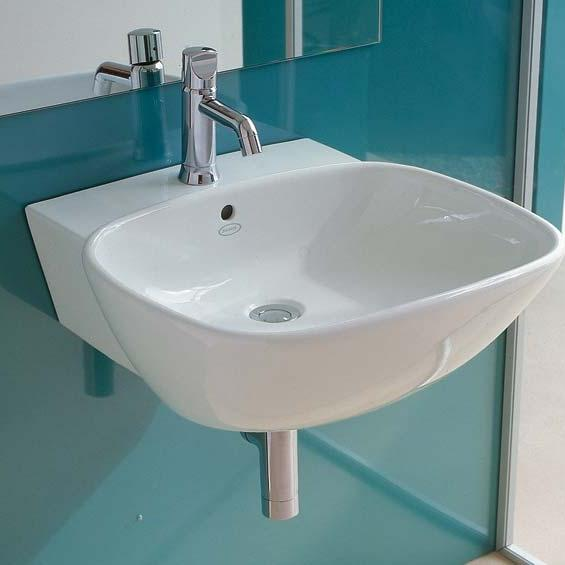

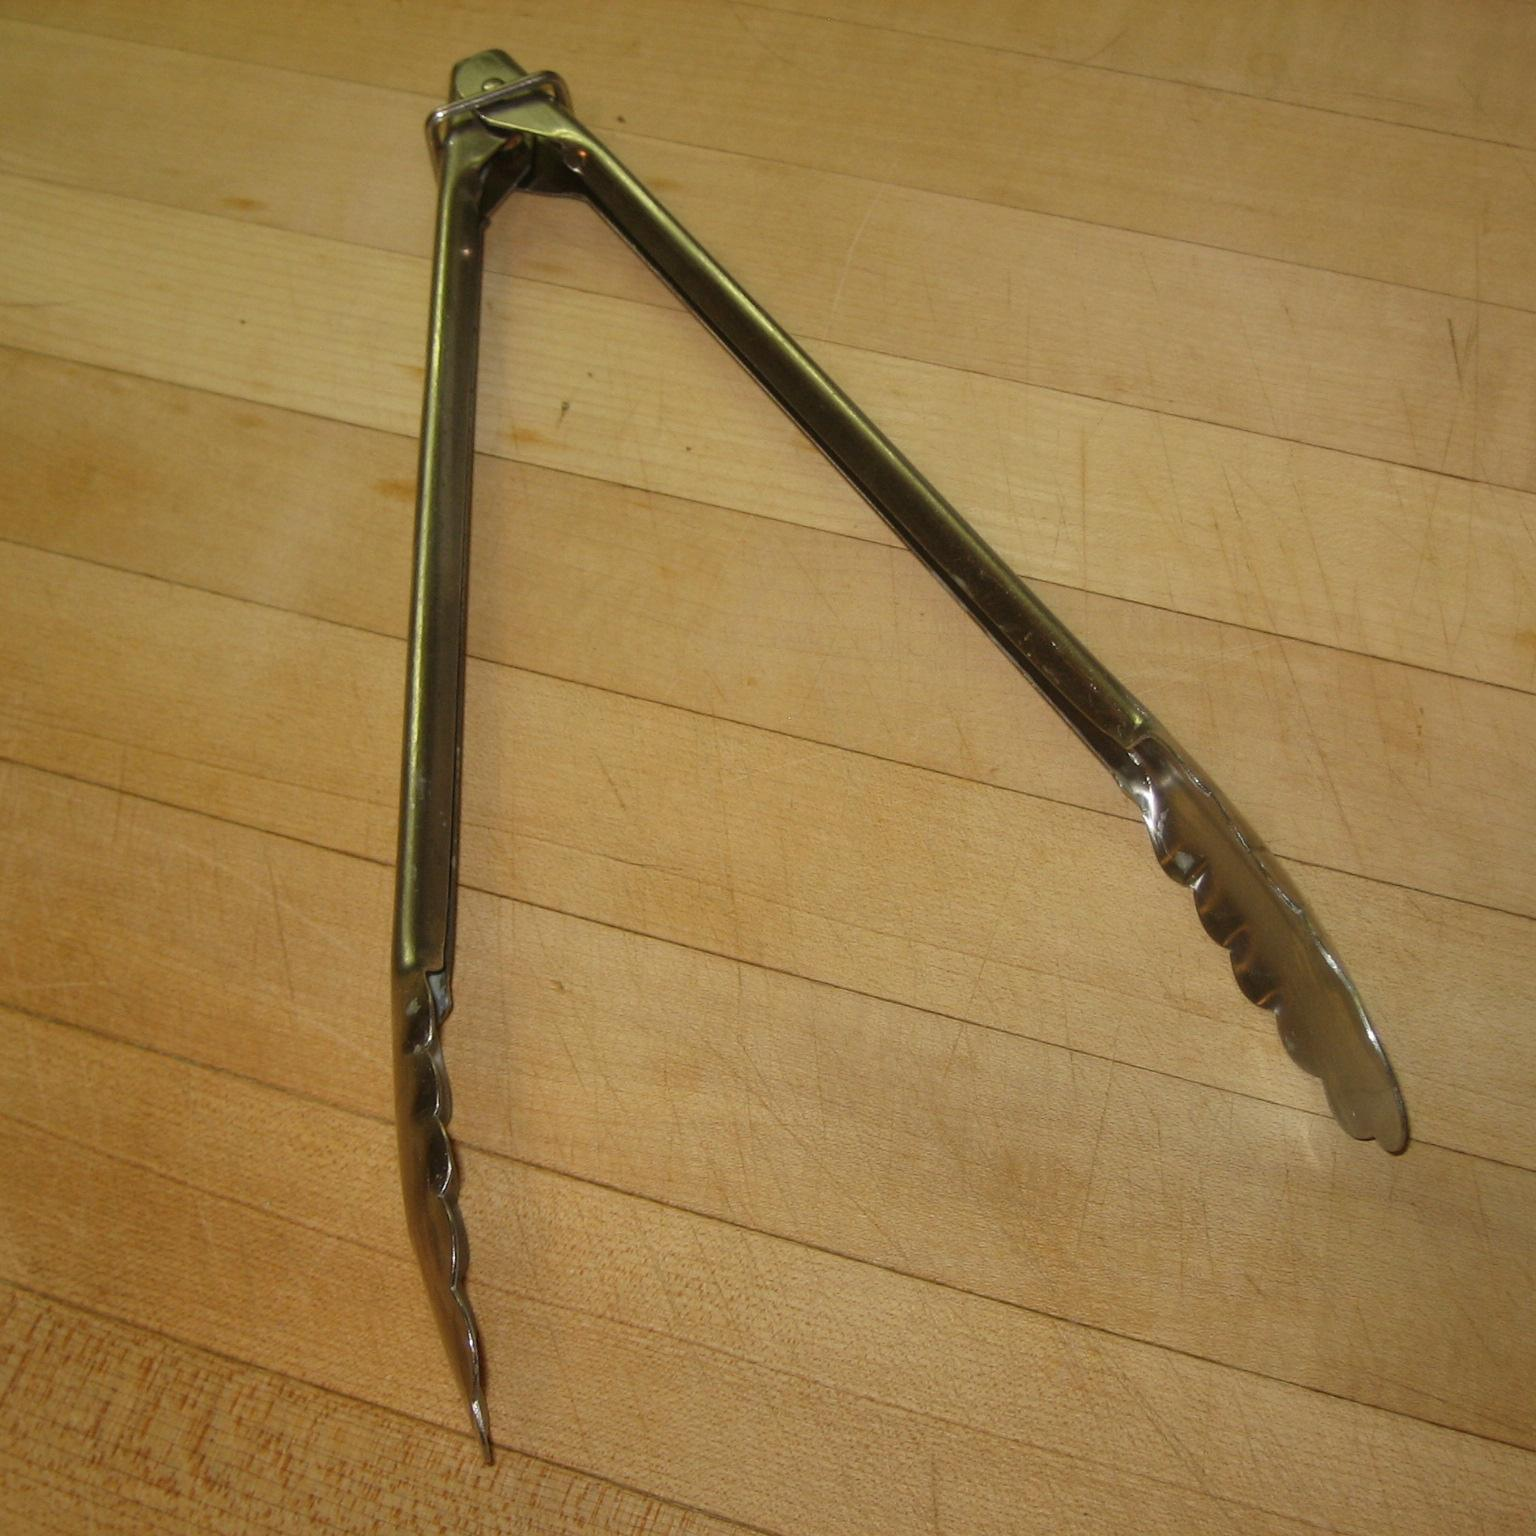

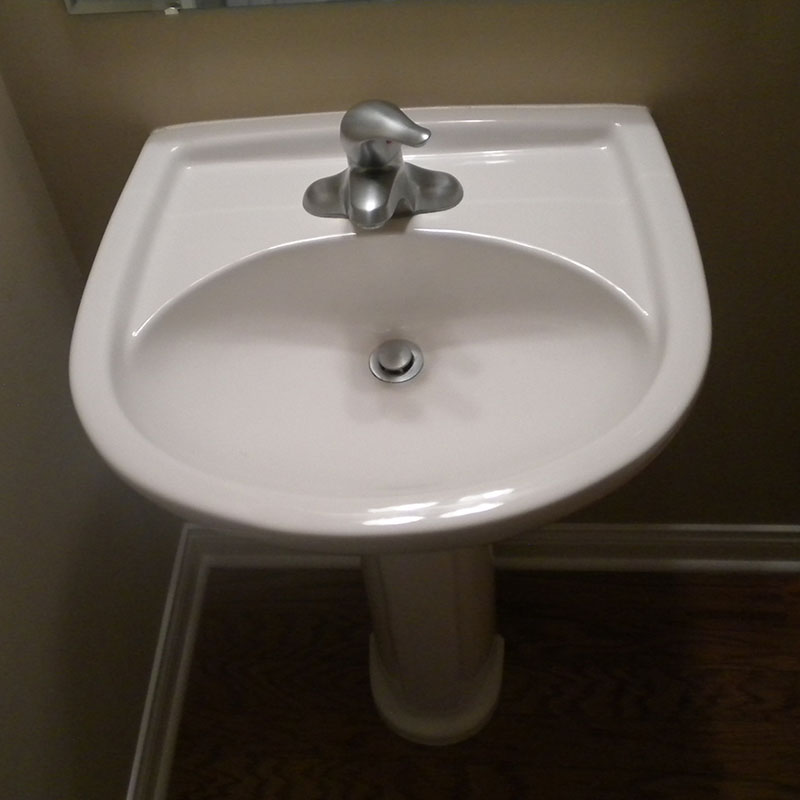

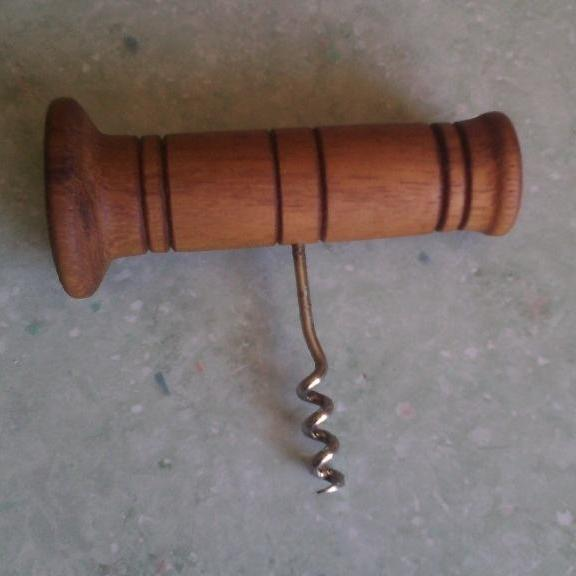

In [203]:
c_dict = pd.Series(
    concepts_info['ids_things'].values, index=concepts_info['synsets']
).to_dict()

for idx, row in test[-10:].iterrows():
    i_path = image_path / c_dict[row['synset']] / f'{row["image"]}.jpg'
    display(Image(i_path, width=300))

# TO-DO
- mainly driven by object -> is the recognition of the object necessary for detecting this?

linear correlation or mutual information between class and ffeature?

correlation of features and corresponding classes vs correlation of tohers

In [215]:
cpreds = {}
fpreds = {}
for m in models:
    m_cpreds = []
    m_fpreds = []
    for s, s_imgs in s_ids.items():
        for img in s_imgs:
            m_cpreds.append(torch.load(
                res_path / m / 'concept_match'/ f'{img}.pt', map_location=torch.device('cpu')
            ))
            m_fpreds.append(torch.load(
                res_path / m / 'feature_match'/ f'{img}.pt', map_location=torch.device('cpu')
            ))
    cpreds[m] = torch.stack(m_cpreds).detach().numpy().T
    fpreds[m] = torch.stack(m_fpreds).detach().numpy().T

In [284]:
corrs = {}
for m in models:
    m_corrs = []
    for idx, row in c_preds[m].iterrows():
        synset = row['synset']
        cp = cpreds[m][synsets.index(row['synset'])]
        s_info = fsk.loc[fsk['synsets']==synset]
        for _, f_row in s_info.iterrows():
            fp = fpreds[m][f_row['features_idx']]
            dist = cdist(cp.reshape(1,-1), fp.reshape(1,-1), 'correlation')
            m_corrs.append([synset, f_row['features'], f_row['features_type'], 1 - dist[0][0]])
    corrs[m] = pd.DataFrame(m_corrs, columns =['synset', 'feature', 'feature_type', 'corr'])

clip
Ttest_relResult(statistic=86.82345743665142, pvalue=0.0)


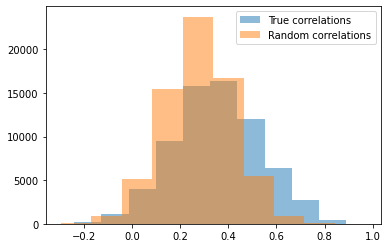

albef
Ttest_relResult(statistic=101.65831703047789, pvalue=0.0)


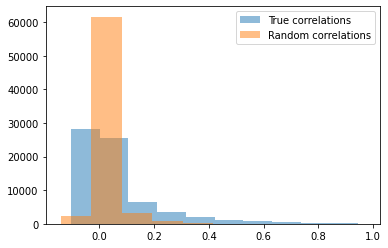

vilt
Ttest_relResult(statistic=98.18612363555445, pvalue=0.0)


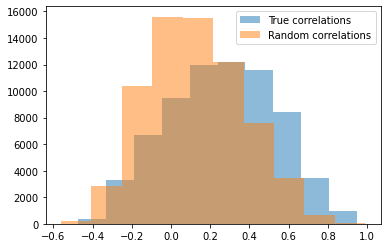

In [287]:
for m in models:
    true_corrs = corrs[m]['corr'].to_numpy()
    random_corrs = []
    for _ in range(len(corrs[m])):
        cp = cpreds[m][np.random.randint(low=0, high=len(cpreds[m]))]
        fp = fpreds[m][np.random.randint(low=0, high=len(fpreds[m]))]
        dist = cdist(cp.reshape(1,-1), fp.reshape(1,-1), 'correlation')
        random_corrs.append(1 - dist[0][0])
    random_corrs = np.array(random_corrs)

    print(m)
    print(ttest_rel(true_corrs, random_corrs))
    
    plt.hist(true_corrs, alpha=0.5, label='True correlations')
    plt.hist(random_corrs, alpha=0.5, label='Random correlations')
    plt.legend(loc='upper right')
    plt.show()

## TO-DO
- Do this feature-wise
- Use mutual information?

# TO-DO
- is there class association in this predictions?